In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
import math as m
from statsmodels.distributions.empirical_distribution import ECDF as ecdf

In [3]:
## Degree correlation functions

# undirected
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graph with degree distribution in G
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    

## k_nn^{mode1,mode2}(l) : average mode2-degree of mode1-neighbours of nodes with mode1-degree = l
def deg_corr_directed(G, mode1='all', mode2='all'):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree(mode=mode1))])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree(mode=mode2)
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v, mode='out')] ## do each link only once
        L[idx[v.degree(mode=mode1)]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L)) if len(L[i])>0}

## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

## for a fixed l -- can be slow for multiple l's
def rich_club(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat     

# Question 1

In [4]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv('musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv('musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] 
lbl = ['web','ml']     
gh.es['color'] = 'grey' 

## there are 2 node types: ml or web
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

In [5]:
## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

## there are 9739 ml developers and 27961 web developers
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount(),'; web developers:',gh_web.vcount())

GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


# 1a) Plotting degree correlation function knn(l) and the uncorrelated counterpart for GitHub Original graph and the subgraphs ml and web developers

Text(0.5, 1.0, 'The degree correlation function $k_{nn}(\\ell)$ - GitHub Original Graph')

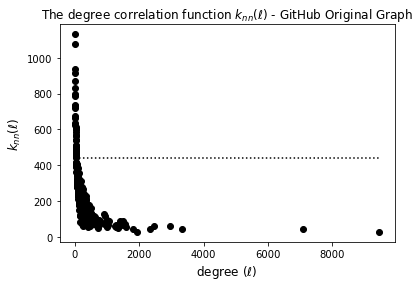

In [6]:
## linear scale plot
knn = deg_corr(gh)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(gh)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
plt.title('The degree correlation function $k_{nn}(\ell)$ - GitHub Original Graph')


C:\Users\Brandon\anaconda3\envs\env2\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Brandon\anaconda3\envs\env2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'The degree correlation function $k_{nn}(\\ell)$ - GitHub ML Subgraph')

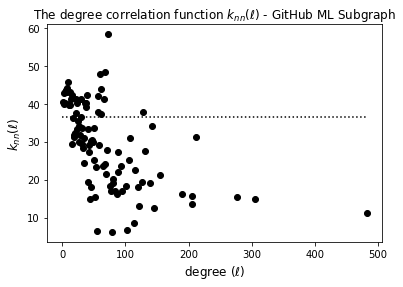

In [7]:
## linear scale plot
knn = deg_corr(gh_ml)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(gh_ml)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
plt.title('The degree correlation function $k_{nn}(\ell)$ - GitHub ML Subgraph')


Text(0.5, 1.0, 'The degree correlation function $k_{nn}(\\ell)$ - GitHub Web Developers Subgraph')

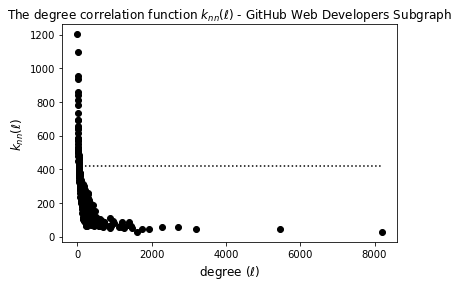

In [8]:
## linear scale plot
knn = deg_corr(gh_web)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(gh_web)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
plt.title('The degree correlation function $k_{nn}(\ell)$ - GitHub Web Developers Subgraph')

# 1b) Degree Correlation Coefficient r

In [9]:
print('The degree correlation coefficient of GitHub Original graph r=', gh.assortativity_degree())
print('The degree correlation coefficient of GitHub ML graph r=', gh_ml.assortativity_degree())
print('The degree correlation coefficient of GitHubWweb Developers subgraph r=', gh_web.assortativity_degree())

The degree correlation coefficient of GitHub Original graph r= -0.07521713413904484
The degree correlation coefficient of GitHub ML graph r= -0.09098692775064465
The degree correlation coefficient of GitHubWweb Developers subgraph r= -0.08714757315866849


# 1c) Correlation Exponent mu

In [10]:
## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    if -m.inf in x:
        x.remove(-m.inf)
    #print(x)
    y = [np.log(i) for i in knn.values()]
    y = [val for val in y if not(np.isnan(val))==True]
    #print(y)
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

In [11]:
print('The correlation exponent of GitHub Original graph \u03BC=', corr_exp(gh))
print('The correlation exponent of GitHub ML subgraph \u03BC=', corr_exp(gh_ml))
print('The correlation exponent of GitHub Web Developers subgraph \u03BC=', corr_exp(gh_web))

The correlation exponent of GitHub Original graph μ= -0.5076879013701245
The correlation exponent of GitHub ML subgraph μ= -0.25142348768180356
The correlation exponent of GitHub Web Developers subgraph μ= -0.5151040696086915


C:\Users\Brandon\anaconda3\envs\env2\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Brandon\anaconda3\envs\env2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Brandon\AppData\Local\Temp/ipykernel_13652/913797430.py:7: RuntimeWarning: divide by zero encountered in log
  x = [np.log(i) for i in knn.keys()]
C:\Users\Brandon\anaconda3\envs\env2\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Brandon\anaconda3\envs\env2\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Brandon\AppData\Local\Temp/ipykernel_13652/913797430.py:7: RuntimeWarning: divide by zero encountered in log
  x = [np.log(i)

# 1d) Plotting the rich-club coefficient

In [12]:
## for a fixed l -- can be slow for multiple l's
def rich_club(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat  

Text(0.5, 1.0, 'Rich-Club Coefficient $\\rho(\\ell)$ plot of GitHub Original graph')

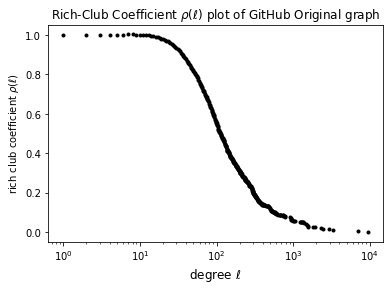

In [14]:
## Plotting the rich-club coefficient!
d = list(set(gh.degree()))
rc = []
for i in d:
    rc.append(rich_club(gh, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
plt.title(r'Rich-Club Coefficient $\rho(\ell)$ plot of GitHub Original graph')

Text(0.5, 1.0, 'Rich-Club Coefficient $\\rho(\\ell)$ plot for GitHub ML Subgraph')

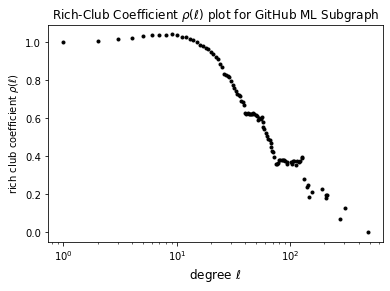

In [15]:
d = list(set(gh_ml.degree()))
rc = []
for i in d:
    rc.append(rich_club(gh_ml, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
plt.title(r'Rich-Club Coefficient $\rho(\ell)$ plot for GitHub ML Subgraph')

Text(0.5, 1.0, 'Rich-Club Coefficient $\\rho(\\ell)$ plot for GitHub Web Developers Subgraph')

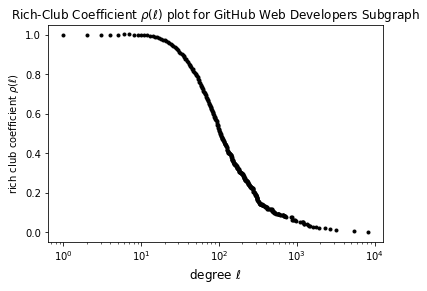

In [16]:
d = list(set(gh_web.degree()))
rc = []
for i in d:
    rc.append(rich_club(gh_web, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
plt.title(r'Rich-Club Coefficient $\rho(\ell)$ plot for GitHub Web Developers Subgraph')

# Question 2

In [11]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv('musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv('musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] 
lbl = ['web','ml']     
gh.es['color'] = 'grey' 

## there are 2 node types: ml or web
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

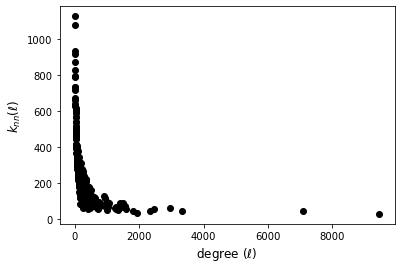

In [12]:
gh_r = gh.copy()
gh_r.rewire()
## linear scale plot
knn = deg_corr(gh_r)
x = list(knn.keys())
y = list(knn.values())
plt.scatter(x,y,c='black')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);

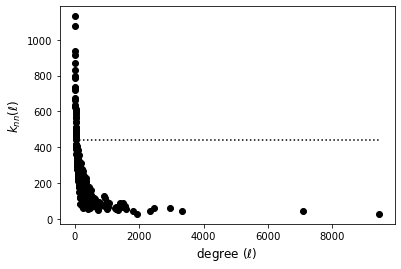

In [13]:
## linear scale plot
knn = deg_corr(gh)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(gh)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);

The graphs look indistinguishable, therefore we can say the correlations in the graph are completely structural, the github devlopers graph is uncorrelated.

# 3) Plotting randomized degree correlation function of GitHub developers graph

In [17]:
## Naive Xulvi-Brunet and Sokolov algorithm
def XBS(g, c, m, q, assortative):
    #p = d/n
    #g = ig.Graph.Erdos_Renyi(n,p)
    g = g.copy()
    g.es['touched'] = False
    ec = g.ecount()
    counter = 0
    while True:
        re = np.random.choice(ec, 2, replace=False)
        #print(re)
        nodes = list(g.es[re[0]].tuple+g.es[re[1]].tuple)
        #print(set(nodes))
        if len(set(nodes))==4:
            #print('Entered first if')
            ## with proba q, wire w.r.t. assortativity, else randomly
            if np.random.random()<q:
                idx = np.argsort(g.degree(nodes))
                if assortative:
                    e1 = (nodes[idx[0]],nodes[idx[1]])
                    e2 = (nodes[idx[2]],nodes[idx[3]])
                else:
                    e1 = (nodes[idx[0]],nodes[idx[3]])
                    e2 = (nodes[idx[1]],nodes[idx[2]])
            else:
                np.random.shuffle(nodes)
                e1 = (nodes[0],nodes[1])
                e2 = (nodes[2],nodes[3])
            if g.get_eid(e1[0], e1[1], directed=False, error=False)+\
               g.get_eid(e2[0], e2[1], directed=False, error=False) == -2:
                    g.delete_edges(re)
                    g.add_edge(e1[0],e1[1],touched=True)
                    g.add_edge(e2[0],e2[1],touched=True)
                    counter+=1
                    #print('edge replaced1')
            else:
                g.es[re[0]]['touched']=True
                g.es[re[1]]['touched']=True
                counter+=1
                #print('edge replaced2')
        #print(sum(g.es['touched']))
        #print('Number of edges not switched is', g.ecount()-counter)
        #print(counter)
        if sum(g.es['touched']) >= c*m:
            break
    print('The actual fraction of edges not switched is', (g.ecount()-sum(g.es['touched']))/g.ecount(), '\n Estimated fraction of edges not switched e^-2c = ', np.exp(-2*c))
    return g

In [18]:
C = [0.5,0.1,0.3,1,2,0.001]
#m = 100
m = gh.ecount()
print(C,m)

[0.5, 0.1, 0.3, 1, 2, 0.001] 289003


In [19]:
git = XBS(gh, C[0], m, 2/3, False)
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(git)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
plt.title('The approximated randomized degree correlation function $k_{nn}(\ell)$ - GitHub Developers graph for c = 0.5')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Brandon\anaconda3\envs\env2\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Brandon\AppData\Local\Temp/ipykernel_13652/3866454839.py", line 1, in <module>
    git = XBS(gh, C[0], m, 2/3, False)
  File "C:\Users\Brandon\AppData\Local\Temp/ipykernel_13652/2195184025.py", line 31, in XBS
    g.delete_edges(re)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Brandon\anaconda3\envs\env2\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Brandon\anaconda3\envs\env2\lib\site-packages\IPyth

TypeError: object of type 'NoneType' has no len()

In [ ]:
git = XBS(gh, C[1], m, 2/3, False)
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(git)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
plt.title('The approximated randomized degree correlation function $k_{nn}(\ell)$ - GitHub Developers graph for c = 0.1')

In [ ]:
git = XBS(gh, C[2], m, 2/3, False)
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(git)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
plt.title('The approximated randomized degree correlation function $k_{nn}(\ell)$ - GitHub Developers graph for c = 0.3')

In [ ]:
git = XBS(gh, C[3], m, 2/3, False)
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(git)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
plt.title('The approximated randomized degree correlation function $k_{nn}(\ell)$ - GitHub Developers graph for c = 1')

In [ ]:
git = XBS(gh, C[4], m, 2/3, False)
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(git)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
plt.title('The approximated randomized degree correlation function $k_{nn}(\ell)$ - GitHub Developers graph for c = 2')

In [ ]:
git = XBS(gh, C[5], m, 2/3, False)
knn = deg_corr(git)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(git)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
plt.title('The approximated randomized degree correlation function $k_{nn}(\ell)$ - GitHub Developers graph for c = 0.001')

#The actual fraction of edges not switched is 0.9989965502088214 
#Estimated fraction of edges not switched e^-2c = 0.9980019986673331
#As seen above the theoretical prediction for the fraction of edges not switched is matching with the experimental results.

# Question 5

In [14]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    new_tpl = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [16]:
def create_CL(gamma):
    ## power law graph
    n = 10000
    ## min and max degrees
    delta = 1
    Delta = np.sqrt(n)

    ## generate degrees
    W = []
    for i in np.arange(1,n+1):
        W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

    # deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
    deg = W

    ## generate graph with Chung-Lu model
    m = int(np.mean(deg)*n/2)
    tpl = fastCL(deg,m)

    G = ig.Graph.TupleList(tpl, weights=True)
    
    return G

## number of isolated nodes (no edges)
#iso = n-G.vcount()
#print('isolates:',iso)

In [17]:
g1 = create_CL(2.1)
g2 = create_CL(2.5)
g3 = create_CL(2.9)

In [39]:
def friendship(g):
    deg = [v.degree() for v in g.vs()]
    nad = []
    for v in g.vs():
        nv = g.neighbors(v)
        nad.append(np.mean([deg[i] for i in nv]))

    plt.scatter(deg,nad,c='black',marker='.')
    plt.xlim((0,200))
    plt.ylim((0,200))
    plt.xlabel('node degree', fontsize=14)
    plt.ylabel('average neighbour degree', fontsize=14);
    plt.plot([0,200],[0,200],'--', c='gray')
    print('r =',g.assortativity_degree());
    
    return

In [40]:
def rich(g):
    ## looking for rich club -- not here!
    d = list(set(g.degree()))
    rc = []
    for i in d:
        rc.append(rich_club(g, l=i))
    plt.semilogx(d,rc,'.',c='black')
    plt.xlabel(r'degree $\ell$',fontsize=12)
    plt.ylabel(r'rich club coefficient $\rho(\ell)$');
    #plt.savefig('rich_club.eps');
    return

r = -0.008559061411073718


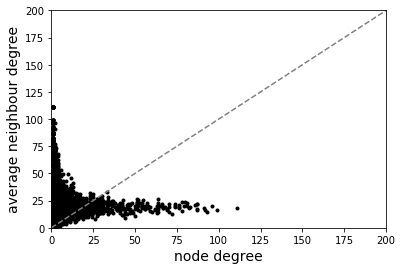

In [41]:
friendship(g1)

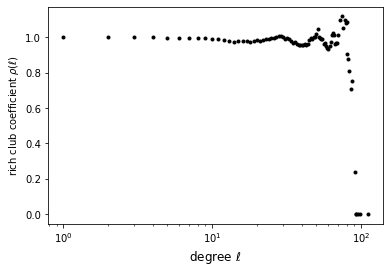

In [42]:
rich(g1)

For gamma = 2.1, we see evidence of the friendship paradox (the dots above the line are much denser). In other words, nodes are connected to nodes whose degree is greater on average.

For the richness coefficiennt, other than the slight jump followed by a steep drop, indicating there is probably no rich-club phenomenom

r = 0.0064664899396441895


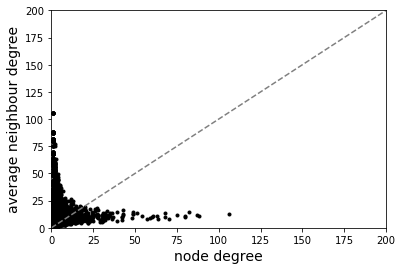

In [43]:
friendship(g2)

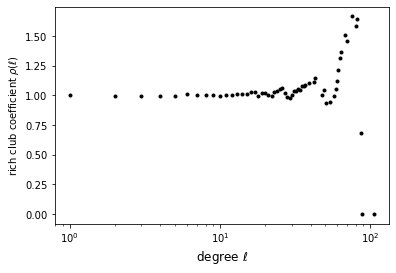

In [44]:
rich(g2)

For gamma = 2.5, we see evidence of the friendship paradox (the dots above the line are much denser). In other words, nodes are connected to nodes whose degree is greater on average.

For the richness coefficiennt, we see a steep incline at around degree > 50, indicating there is a rich-club phenomenom (high degree nodes have lots of edges in between them)

r = -0.01602797328024216


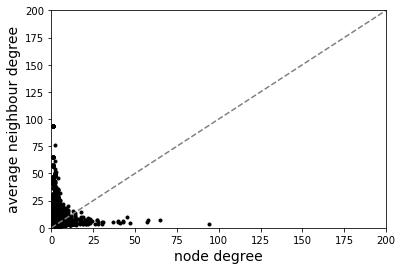

In [45]:
friendship(g3)

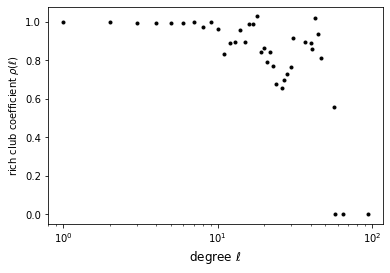

In [46]:
rich(g3)

For gamma = 2.1, we see evidence of the friendship paradox (the dots above the line are much denser). In other words, nodes are connected to nodes whose degree is greater on average.

For the richness coefficiennt, starting at 1, it remains steady and then becomes unsteady in a decreasing trend with seemingly no pattern, indicating there is no rich-club phenomenom